In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
import pickle


%matplotlib inline

In [2]:
df = pd.read_parquet("../data/yellow_tripdata_2024-07.parquet")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-07-01 00:34:56,2024-07-01 00:46:49,1.0,3.20,1.0,N,140,79,1,15.6,3.50,0.5,3.50,0.00,1.0,24.10,2.5,0.00
1,2,2024-06-30 23:48:58,2024-07-01 00:28:04,1.0,19.48,2.0,N,132,113,2,70.0,0.00,0.5,0.00,0.00,1.0,75.75,2.5,1.75
2,2,2024-07-01 00:23:18,2024-07-01 00:29:51,1.0,1.18,1.0,N,237,145,1,8.6,1.00,0.5,2.72,0.00,1.0,16.32,2.5,0.00
3,1,2024-07-01 00:10:33,2024-07-01 00:27:31,0.0,9.10,1.0,N,138,164,1,36.6,10.25,0.5,12.05,0.00,1.0,60.40,2.5,1.75
4,1,2024-07-01 00:07:55,2024-07-01 00:34:34,1.0,17.70,2.0,N,132,263,1,70.0,1.75,0.5,10.00,6.94,1.0,90.19,0.0,1.75


Read Data

In [3]:
categories = ["PULocationID", "DOLocationID"]
numerics = [
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "tip_amount",
    "congestion_surcharge",
    "Airport_fee",
    "tpep_pickup_datetime",
]


def read_data(filename):
    df = pd.read_parquet(filename)
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["duration"] = df["duration"].map(lambda x: x.total_seconds() / 60)

    df = df[(df["duration"] >= 0) & (df["duration"] <= 60)]
    df[categories] = df[categories].astype(object)

    df["tpep_pickup_datetime"] = df["tpep_pickup_datetime"].astype(int)

    prepped = df[categories + numerics + ["duration"]].dropna()
    return prepped

In [4]:
train_data = read_data("../data/yellow_tripdata_2024-07.parquet")

In [5]:
train_data["duration"].describe(percentiles=[0.5, 0.95, 0.99])

count    2.744683e+06
mean     1.543395e+01
std      1.132925e+01
min      0.000000e+00
50%      1.233333e+01
95%      4.000000e+01
99%      5.395300e+01
max      6.000000e+01
Name: duration, dtype: float64

In [6]:
train_data.head()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,tip_amount,congestion_surcharge,Airport_fee,tpep_pickup_datetime,duration
0,140,79,3.20,1.0,15.6,3.50,2.5,0.00,1719794096000000,11.883333
1,132,113,19.48,1.0,70.0,0.00,2.5,1.75,1719791338000000,39.100000
2,237,145,1.18,1.0,8.6,2.72,2.5,0.00,1719793398000000,6.550000
3,138,164,9.10,0.0,36.6,12.05,2.5,1.75,1719792633000000,16.966667
4,132,263,17.70,1.0,70.0,10.00,0.0,1.75,1719792475000000,26.650000


Training pipeline


In [7]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_data[categories + numerics].to_dict(orient="records"))

In [8]:
dv.feature_names_

['Airport_fee',
 'DOLocationID',
 'PULocationID',
 'congestion_surcharge',
 'fare_amount',
 'passenger_count',
 'tip_amount',
 'tpep_pickup_datetime',
 'trip_distance']

In [9]:
target = "duration"
y_train = train_data[target].values
y_train

array([11.88333333, 39.1       ,  6.55      , ...,  6.73333333,
       23.28333333, 10.65      ])

Linear Regression

In [10]:
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

Evaluation pipeline

In [11]:
test_data = read_data("../data/yellow_tripdata_2024-08.parquet")
x_test_dict = test_data[categories + numerics].to_dict(orient="records")
x_test = dv.transform(x_test_dict)
y_test = test_data[target].values

In [12]:
preds = lm.predict(x_test)

In [13]:
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(
    f"The model has an average error of {rmse:.2f} minutes,while explaining {r2:.2f} of the variance"
)

The model has an average error of 11.40 minutes,while explaining -0.00 of the variance


In [14]:
resids = pd.DataFrame({"actual": y_test, "predicted": preds})
resids["residual"] = resids["actual"] - resids["predicted"]
resids["abs_resid"] = resids["residual"].abs()
resids.sort_values("abs_resid", ascending=False)

,actual,predicted,residual,abs_resid
12705,60.000000,15.637937,44.362063,44.362063
21149,60.000000,15.639493,44.360507,44.360507
45774,60.000000,15.641595,44.358405,44.358405
45648,60.000000,15.641644,44.358356,44.358356
13525,59.983333,15.637853,44.345480,44.345480
...,...,...,...,...
2539626,16.033333,16.033310,0.000023,0.000023
899911,15.766667,15.766683,-0.000016,0.000016
2537592,16.033333,16.033319,0.000014,0.000014
1708577,15.900000,15.899988,0.000012,0.000012


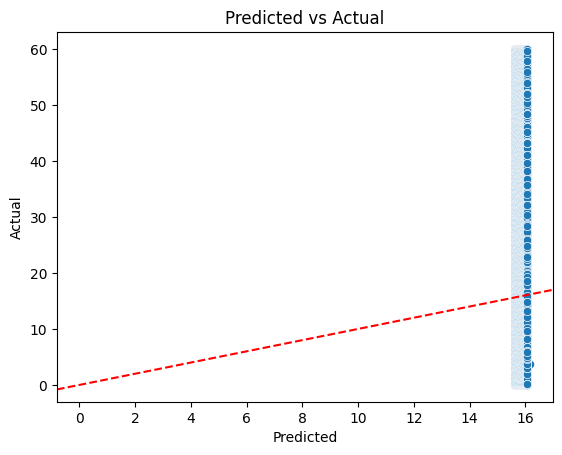

In [52]:
sns.scatterplot(x="predicted", y="actual", data=resids)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual")
# 45 degree line
plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.show()

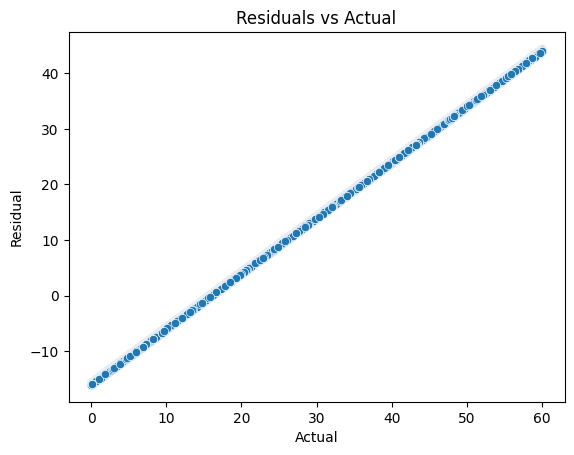

In [53]:
sns.scatterplot(x="actual", y="residual", data=resids)
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.title("Residuals vs Actual")
plt.show()

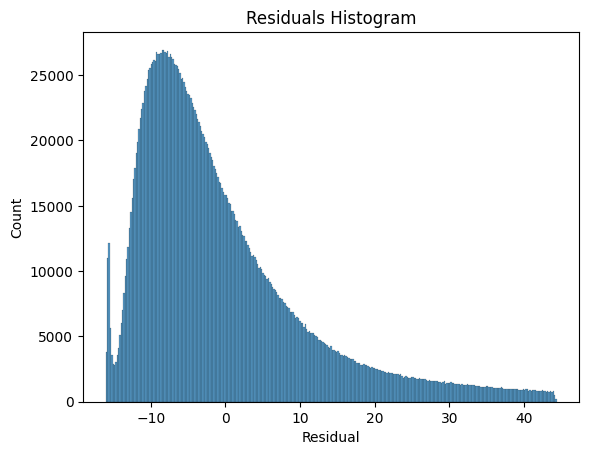

In [54]:
sns.histplot(resids["residual"])
plt.xlabel("Residual")
plt.title("Residuals Histogram")
plt.show()

In [16]:
with open("../models/intro_lm.bin", "wb") as f_out:
    pickle.dump((dv, lm), f_out)

Ridge Regression

In [18]:
ridge = Ridge()
ridge.fit(x_train, y_train)
preds = ridge.predict(x_test)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(
    f"The model has an average error of {rmse:.2f} minutes,while explaining {r2:.2f} of the variance"
)

The model has an average error of 11.40 minutes,while explaining -0.00 of the variance


In [19]:
with open("../models/intro_ridge.bin", "wb") as f_out:
    pickle.dump((dv, ridge), f_out)

Lasso Regression

In [21]:
lasso = Lasso()
lasso.fit(x_train, y_train)
preds = lasso.predict(x_test)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(
    f"The model has an average error of {rmse:.2f} minutes,while explaining {r2:.2f} of the variance"
)

The model has an average error of 8.05 minutes,while explaining 0.50 of the variance


In [22]:
with open("../models/intro_lasso.bin", "wb") as f_out:
    pickle.dump((dv, lasso), f_out)